In [1]:
import os 

os.chdir(r'C:\Users\metro\FINAL_PROJECT_python\data')
os.getcwd()

'C:\\Users\\metro\\FINAL_PROJECT_python\\data'

In [2]:
import pandas as pd
import numpy as np


air = pd.read_csv(r'AirPassengers.csv')

In [3]:
air

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
air = pd.read_csv(r'AirPassengers.csv',parse_dates=['Month'],index_col=['Month'])

In [5]:
air

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [6]:
air.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


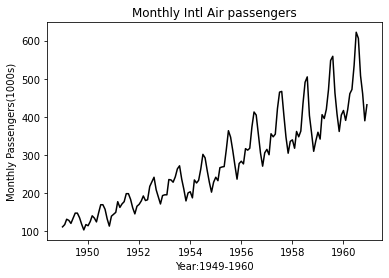

In [7]:
from matplotlib import pyplot as plt
from matplotlib.dates import DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots()

plt.xlabel('Year:1949-1960')
plt.ylabel('Monthly Passengers(1000s)')
plt.title('Monthly Intl Air passengers')
plt.plot(air,color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

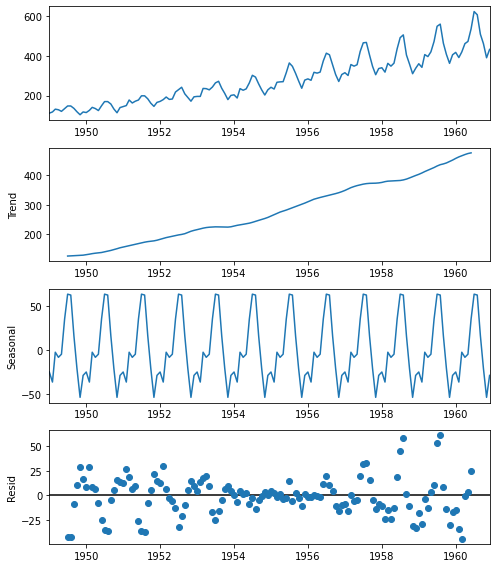

In [8]:
plt.rcParams['figure.figsize'] = [7,8]

sd = seasonal_decompose(air,period=12).plot()

In [9]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [10]:
from pmdarima.arima import auto_arima

In [14]:
trn = air.loc[air.index < '1958-01-01']

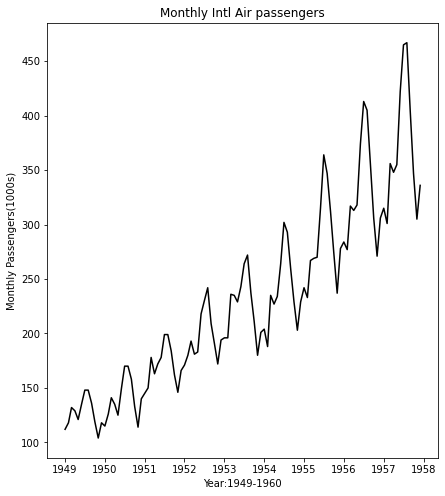

In [15]:
fig, ax = plt.subplots()

plt.xlabel('Year:1949-1960')
plt.ylabel('Monthly Passengers(1000s)')
plt.title('Monthly Intl Air passengers')
plt.plot(trn,color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [16]:
tst = air.loc[air.index >= '1958-01-01']

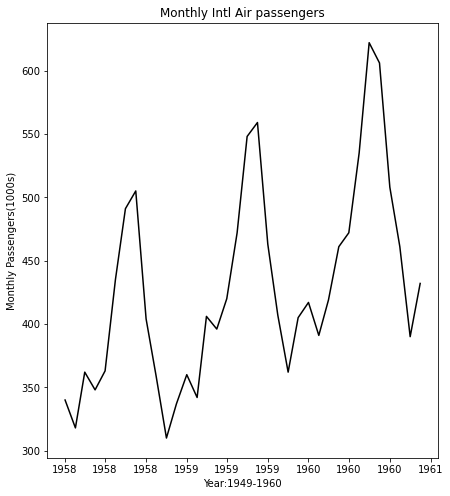

In [17]:
fig, ax = plt.subplots()

plt.xlabel('Year:1949-1960')
plt.ylabel('Monthly Passengers(1000s)')
plt.title('Monthly Intl Air passengers')
plt.plot(tst,color='black')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

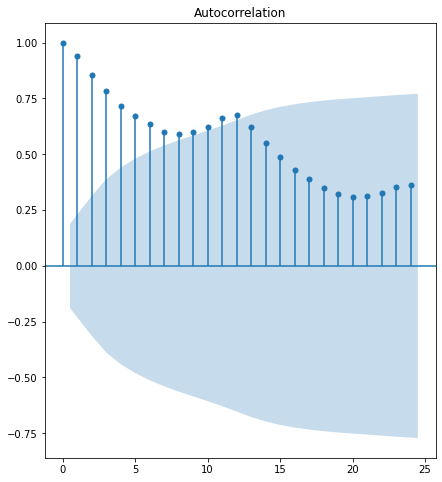

In [20]:
#arima requires non stationary data,the data  where the mean,variance and covariance very over time
from statsmodels.graphics.tsaplots import plot_acf
trn_acf = plot_acf(trn,lags=24)

In [24]:
import statsmodels.api as sm
lr = sm.OLS(endog=trn['#Passengers'], exog = sm.add_constant(np.arange(1,1 + trn.shape[0]))).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:            #Passengers   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     526.7
Date:                Thu, 12 Aug 2021   Prob (F-statistic):           6.40e-43
Time:                        10:58:39   Log-Likelihood:                -536.80
No. Observations:                 108   AIC:                             1078.
Df Residuals:                     106   BIC:                             1083.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         95.0422      6.820     13.936      0.0

In [26]:
y_hat = lr.fittedvalues

In [27]:
y_ci = lr.get_prediction().conf_int(alpha=0.05)

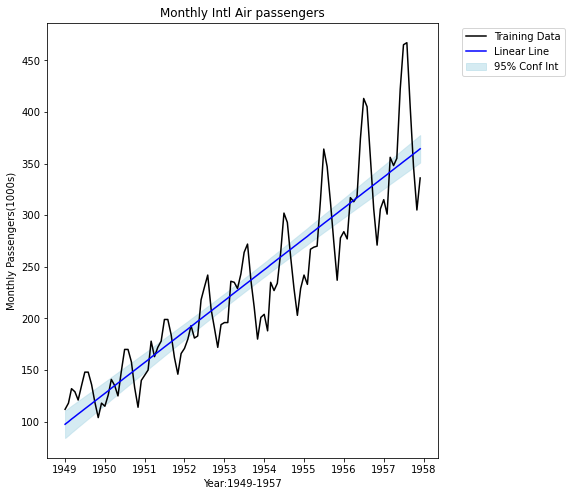

In [28]:
fig, ax = plt.subplots()

plt.xlabel('Year:1949-1957')
plt.ylabel('Monthly Passengers(1000s)')
plt.title('Monthly Intl Air passengers')
plt.plot(trn,color='black' ,label='Training Data')
plt.plot(y_hat,color='blue' ,label='Linear Line')
plt.fill_between(y_hat.index,y_ci[:,0],y_ci[:,1],color='lightblue',alpha=0.5,label="95% Conf Int")
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [32]:
auto_arima_model = auto_arima(trn,m=12 ,with_intercept=False ,suppress_warnings=True)
print(auto_arima_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Thu, 12 Aug 2021   AIC                            704.001
Time:                                    11:20:49   BIC                            709.109
Sample:                                         0   HQIC                           706.065
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439   

1 #p : AUTO -regressive(AR) model
1 #d :Integrate(I) or degree of differencing
0 #q : Moving Average order(MA)

In [31]:
auto_arima_model.order

(1, 1, 0)

In [33]:
auto_arima_model.seasonal_order

(0, 1, 0, 12)

0 #p : AUTO -regressive(AR) model
1 #d :Integrate(I) or degree of differencing
0 #q : Moving Average order(MA)
1 #M : Model period or seasonality

In [35]:
resid  = auto_arima_model.resid()

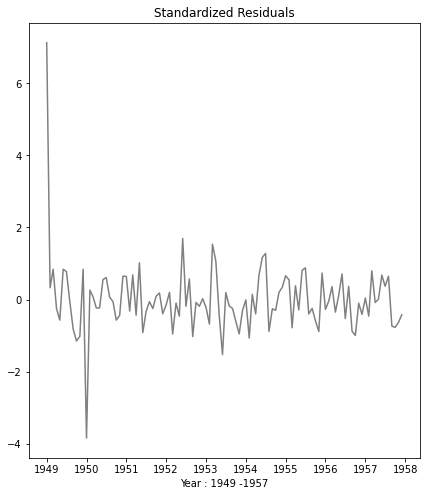

In [37]:
from scipy import stats
fig, ax = plt.subplots()

plt.plot(trn.index, stats.zscore(resid),color='grey')
plt.title('Standardized Residuals')
plt.xlabel('Year : 1949 -1957')
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

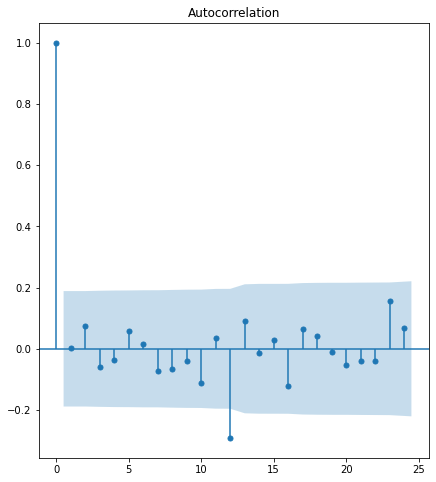

In [38]:
res_acf = plot_acf(resid,lags=24)

Ljung BOX Test for autocorrelation

In [39]:
res_lb = acorr_ljungbox(resid ,lags= 24 , return_df = False)[1]

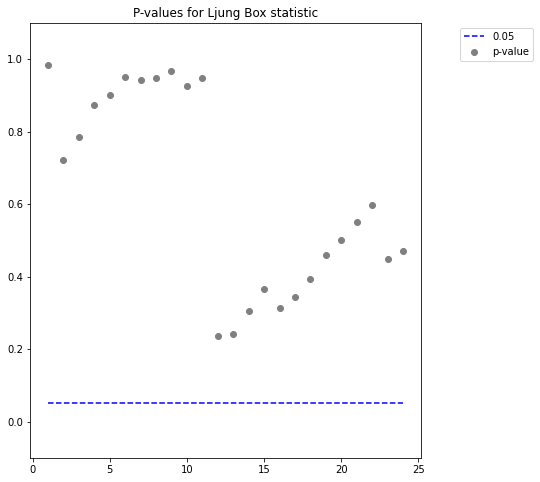

In [41]:
fig, ax = plt.subplots()

plt.title('P-values for Ljung Box statistic')
plt.scatter(np.arange(1 ,1 + len(res_lb)),res_lb,color='grey',label='p-value')
plt.plot(np.arange(1 ,1 + len(res_lb)),[0.05]*len(res_lb),'--',color='blue',label='0.05')
plt.ylim(-0.1,1.1)
plt.legend(bbox_to_anchor=(1.3,1))

In [84]:
auto_arima_model.fit(trn)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

use the model to predict intervals for last 3 years


In [85]:
arima_predictions = auto_arima_model.predict(n_periods = 36 ,alpha =0.05 ,return_conf_int=True)

extract time series of model predictions

In [87]:
y_pred = pd.Series(arima_predictions[0],index=tst.index)

In [81]:
arima_predictions[0]

array([345.96447116, 331.73192001, 386.78799223, 378.77447222,
       385.77773213, 452.77694611, 495.77713563, 497.77708994,
       434.77710095, 377.7770983 , 335.77709894, 366.77709878,
       376.74156998, 362.50901882, 417.56509104, 409.55157103,
       416.55483095, 483.55404492, 526.55423445, 528.55418875,
       465.55419977, 408.55419711, 366.55419775, 397.5541976 ,
       407.5186688 , 393.28611763, 448.34218986, 440.32866985,
       447.33192976, 514.33114374, 557.33133326, 559.33128756,
       496.33129858, 439.33129592, 397.33129657, 428.33129641])

In [80]:
arima_predictions[1]

array([[327.08869921, 364.84024311],
       [308.03623033, 355.42760969],
       [358.51574099, 415.06024346],
       [346.69545456, 410.85348987],
       [350.27076518, 421.28469909],
       [414.15107441, 491.40281781],
       [454.26467915, 537.28959211],
       [453.56642474, 541.98775513],
       [388.02361606, 481.53058585],
       [328.61214939, 426.94204721],
       [284.31355423, 387.24064365],
       [313.11332539, 420.44087218],
       [313.16837655, 440.31476342],
       [292.41080689, 432.60723075],
       [341.06678294, 494.06339914],
       [327.24675231, 491.85638976],
       [328.80487934, 504.30478255],
       [390.68268852, 576.42540132],
       [428.82834579, 624.2801231 ],
       [426.20402813, 630.90434937],
       [358.77979009, 572.32860945],
       [297.53171928, 519.57667494],
       [251.44030907, 481.66808643],
       [278.48940865, 516.61898654],
       [278.65347486, 536.38386273],
       [256.87470913, 529.69752613],
       [304.4348938 , 592.24948591],
 

In [79]:
arima_predictions[1][:,0]

array([327.08869921, 308.03623033, 358.51574099, 346.69545456,
       350.27076518, 414.15107441, 454.26467915, 453.56642474,
       388.02361606, 328.61214939, 284.31355423, 313.11332539,
       313.16837655, 292.41080689, 341.06678294, 327.24675231,
       328.80487934, 390.68268852, 428.82834579, 426.20402813,
       358.77979009, 297.53171928, 251.44030907, 278.48940865,
       278.65347486, 256.87470913, 304.4348938 , 289.3771575 ,
       289.63212726, 350.1644832 , 386.94208589, 382.93906213,
       314.13371779, 251.50772192, 204.04541347, 229.73328539])

In [88]:
y_pred_lb ,y_pred_ub = arima_predictions[1][:,0],arima_predictions[1][:,1]

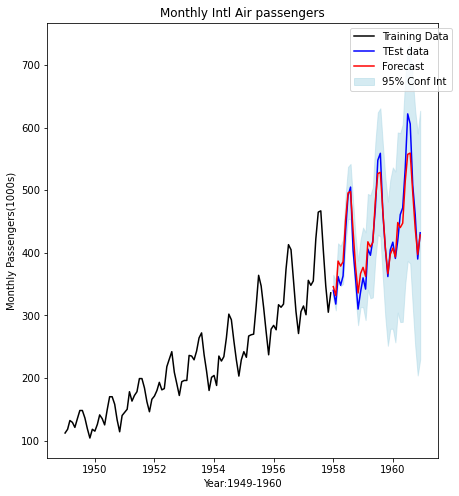

In [94]:
fig, ax = plt.subplots()

plt.xlabel('Year:1949-1960')
plt.ylabel('Monthly Passengers(1000s)')
plt.title('Monthly Intl Air passengers')
plt.fill_between(tst.index,y_pred_lb,y_pred_ub,color='lightblue',alpha=0.5,label="95% Conf Int")
plt.plot(trn,color='black' ,label='Training Data')
plt.plot(tst,color='blue' ,label='TEst data')
plt.plot(y_pred,color='red',label='Forecast')
plt.legend(bbox_to_anchor=(1.05, 1))
ax.xaxis.set_major_formatter(DateFormatter('%Y'))

In [90]:
tst_pred = pd. DataFrame({
    'Actual' : tst.iloc[:,0].values,
    'point Forecast' : y_pred.values,
    'Lo 95': y_pred_lb,
    'Hi 95':y_pred_ub
},index =tst.index)

In [93]:
tst_pred.head(20)

,Actual,point Forecast,Lo 95,Hi 95
Month,,,,
1958-01-01,340,345.964471,327.088699,364.840243
1958-02-01,318,331.731920,308.036230,355.427610
1958-03-01,362,386.787992,358.515741,415.060243
1958-04-01,348,378.774472,346.695455,410.853490
1958-05-01,363,385.777732,350.270765,421.284699
1958-06-01,435,452.776946,414.151074,491.402818
1958-07-01,491,495.777136,454.264679,537.289592
1958-08-01,505,497.777090,453.566425,541.987755
1958-09-01,404,434.777101,388.023616,481.530586
